In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
%matplotlib inline

In [2]:
path = os.getcwd()
path

'/Users/ekaterinagalin/Documents/Python/Data Camp'

In [3]:
data = pd.read_csv('Customer Churn.csv')
data_prep = data.copy()
data_prep.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.groupby(['Churn']).size() / data.shape[0] * 100

Churn
No     73.463013
Yes    26.536987
dtype: float64

In [5]:
custid = ['customerID']
target = ['Churn']

#store categorical column names
cat = data_prep.nunique()[data_prep.nunique() < 10].keys().tolist()
cat.remove(target[0])

#store numerical column names
num = [x for x in data_prep.columns if x not in custid + target + cat]
num

['tenure', 'MonthlyCharges', 'TotalCharges']

In [6]:
#one-hot encoding to categorical variables
data_prep = pd.get_dummies (data = data_prep, columns = cat, drop_first = True)
data_prep['Churn'] = data_prep['Churn'].replace({'No': 0, 'Yes' : 1})

In [7]:
#identify and drop missing values
drop = data_prep.loc[pd.to_numeric(data_prep['TotalCharges'], errors='coerce').isnull()].index
data_prep = data_prep.drop(drop)

In [8]:
scaler = StandardScaler()
scaled_num = scaler.fit_transform(data_prep[num])
scaled_num = pd.DataFrame(scaled_num, columns = num)

In [9]:
#drop non-scaled numerical columns
data_prep = data_prep.drop(columns = num, axis = 1)

In [10]:
#merge non-numerical with scaled numerical columns
telco = data_prep.merge(right = scaled_num, how = 'left', left_index = True, right_index = True)
telco.dtypes

customerID                                object
Churn                                      int64
gender_Male                                uint8
SeniorCitizen_1                            uint8
Partner_Yes                                uint8
Dependents_Yes                             uint8
PhoneService_Yes                           uint8
MultipleLines_No phone service             uint8
MultipleLines_Yes                          uint8
InternetService_Fiber optic                uint8
InternetService_No                         uint8
OnlineSecurity_No internet service         uint8
OnlineSecurity_Yes                         uint8
OnlineBackup_No internet service           uint8
OnlineBackup_Yes                           uint8
DeviceProtection_No internet service       uint8
DeviceProtection_Yes                       uint8
TechSupport_No internet service            uint8
TechSupport_Yes                            uint8
StreamingTV_No internet service            uint8
StreamingTV_Yes     

In [11]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

telco.fillna(telco.mean(), inplace=True)

In [12]:
X = telco.drop(labels = ['Churn', 'customerID'],axis = 1)
y = data_prep ['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25 )

#ensure training dataset has only 75% of original X data
print(X_train.shape[0] / X.shape [0])

0.75


In [13]:
#decision tree
mytree = tree.DecisionTreeClassifier(max_depth = 5)
treemodel = mytree.fit (X_train, y_train)
y_pred = treemodel.predict (X_test)
accuracy_score(y_test, y_pred)

0.7622298065984073

In [14]:
clf = tree.DecisionTreeClassifier(max_depth = 7, criterion = 'gini', splitter = 'best')
clf = clf.fit(X_train, y_train)
y_pred = clf.predict (X_test)

print ('Train Accuracy: ', np.round(clf.score(X_train, y_train), 3))
print ('Test Accuracy: ', np.round(accuracy_score(y_test, y_pred), 3))

Train Accuracy:  0.798
Test Accuracy:  0.751


In [15]:
#tuning max_depth

from sklearn.tree import DecisionTreeClassifier
depth_list = list(range(2,15))
depth_tuning = np.zeros((len(depth_list), 4))
depth_tuning [:, 0] = depth_list

for index in range (len(depth_list)):
    
    mytree = DecisionTreeClassifier(max_depth = depth_list[index])
    mytree.fit(X_train, y_train)
    y_pred = mytree.predict (X_test)
    
   
    depth_tuning[index, 1] = accuracy_score(y_test, y_pred)
    depth_tuning[index, 2] = precision_score(y_test, y_pred)
    depth_tuning[index, 3] = recall_score(y_test, y_pred)
    
col_names = ['Max_Depth', 'Accuracy', 'Precision', 'Recall']
print(pd.DataFrame(depth_tuning, columns = col_names))

    Max_Depth  Accuracy  Precision    Recall
0         2.0  0.720137   0.000000  0.000000
1         3.0  0.741752   0.533808  0.609756
2         4.0  0.754266   0.563025  0.544715
3         5.0  0.762230   0.625850  0.373984
4         6.0  0.755973   0.592375  0.410569
5         7.0  0.750284   0.557734  0.520325
6         8.0  0.751422   0.568922  0.461382
7         9.0  0.746303   0.550439  0.510163
8        10.0  0.741183   0.540839  0.497967
9        11.0  0.737770   0.531568  0.530488
10       12.0  0.725825   0.509921  0.522358
11       13.0  0.714448   0.490196  0.508130
12       14.0  0.718999   0.498084  0.528455


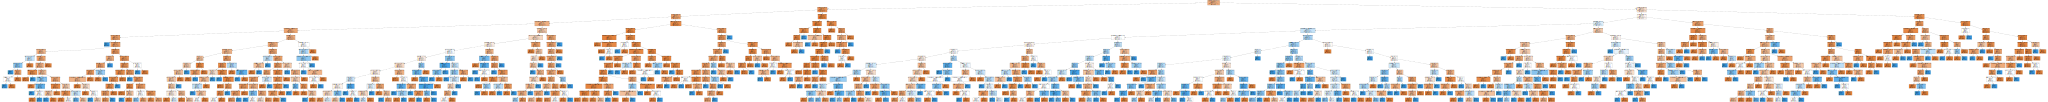

In [16]:
#plot a decision tree

from sklearn import tree
import graphviz


exported = tree.export_graphviz(
decision_tree = mytree,
out_file = None,
feature_names = X_train.columns,
precision = 1,
class_names = ['Not churn', 'Churn'],
filled = True)

graph = graphviz.Source(exported)
display(graph)

0.8174785509703438


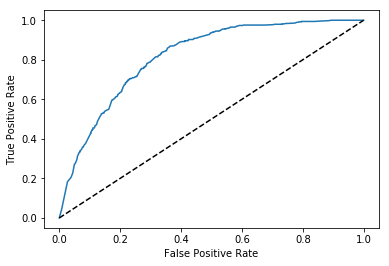

In [29]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred_prob))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

lr = LogisticRegression(C = 0.025, penalty = 'l1', solver ='saga')
lr.fit(X_train, y_train)
y_pred = lr.predict (X_test)

print ('Train Accuracy: ', np.round(lr.score(X_train, y_train), 3))
print ('Test Accuracy: ', np.round(accuracy_score(y_test, y_pred), 3))
print('Precision Score: ', np.round(precision_score (y_test, y_pred),3))
print('Recall Score: ', np.round(recall_score(y_test, y_pred), 3))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Train Accuracy:  0.785
Test Accuracy:  0.763
Precision Score:  0.629
Recall Score:  0.376
[[1157  109]
 [ 307  185]]
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1266
           1       0.63      0.38      0.47       492

    accuracy                           0.76      1758
   macro avg       0.71      0.64      0.66      1758
weighted avg       0.75      0.76      0.74      1758



In [18]:
#tuning L1 Regularisation
C = [1, .5, .25, .1, .05, .025, .01, .005, .0025]
l1_metrics = np.zeros((len(C), 5))
l1_metrics [:, 0] = C

for index in range (0, len(C)):
    
    logreg = LogisticRegression (penalty = 'l1', C=C[index], solver = 'liblinear')
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict (X_test)
    
    l1_metrics[index, 1] = np.count_nonzero(logreg.coef_)
    l1_metrics[index, 2] = accuracy_score(y_test, y_pred)
    l1_metrics[index, 3] = precision_score(y_test, y_pred)
    l1_metrics[index, 4] = recall_score(y_test, y_pred)
    
col_names = ['C', 'Non-Zero Coeffs', 'Accuracy', 'Precision', 'Recall']
print(pd.DataFrame(l1_metrics, columns = col_names))

        C  Non-Zero Coeffs  Accuracy  Precision    Recall
0  1.0000             26.0  0.770193   0.607843  0.504065
1  0.5000             27.0  0.769625   0.606880  0.502033
2  0.2500             27.0  0.771900   0.612346  0.504065
3  0.1000             26.0  0.772469   0.616162  0.495935
4  0.0500             19.0  0.770762   0.614396  0.485772
5  0.0250             18.0  0.764505   0.612069  0.432927
6  0.0100              9.0  0.751422   0.660819  0.229675
7  0.0050              6.0  0.720137   0.000000  0.000000
8  0.0025              0.0  0.720137   0.000000  0.000000


In [19]:
#coefficients
coefficients = pd.concat([pd.DataFrame(X_train.columns),
                         pd.DataFrame (np.transpose(lr.coef_))],
                        axis = 1)
coefficients.columns = ['Feature', 'Coefficient']
coefficients ['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])
coefficients = coefficients[coefficients['Coefficient'] != 0]
print (coefficients.sort_values(by = ['Coefficient']))

                                 Feature  Coefficient  Exp_Coefficient
22                     Contract_Two year    -1.565772         0.208927
21                     Contract_One year    -0.891163         0.410179
10                    OnlineSecurity_Yes    -0.355058         0.701133
2                            Partner_Yes    -0.185027         0.831082
16                       TechSupport_Yes    -0.169999         0.843666
12                      OnlineBackup_Yes    -0.134107         0.874497
13  DeviceProtection_No internet service    -0.071508         0.930989
8                     InternetService_No    -0.071508         0.930989
9     OnlineSecurity_No internet service    -0.071508         0.930989
11      OnlineBackup_No internet service    -0.071508         0.930989
15       TechSupport_No internet service    -0.071508         0.930989
17       StreamingTV_No internet service    -0.071508         0.930989
19   StreamingMovies_No internet service    -0.071508         0.930989
1     

In [27]:
#adjust probabilities
y_pred_prob = lr.predict_proba(X_test)[:, 1]

#classification based on the probability values
y_new_pred = []
threshold = 0.4

for i in range (0, len(y_pred_prob)):
    if y_pred_prob[i] > threshold:
        y_new_pred.append(1)
    else:
        y_new_pred.append(0)
        
print (confusion_matrix(y_test, y_new_pred))
print (lr.score(X_test, y_new_pred))
print (classification_report (y_test, y_new_pred))

[[1029  237]
 [ 190  302]]
0.8606370875995449
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1266
           1       0.56      0.61      0.59       492

    accuracy                           0.76      1758
   macro avg       0.70      0.71      0.71      1758
weighted avg       0.76      0.76      0.76      1758



0.8174785509703438


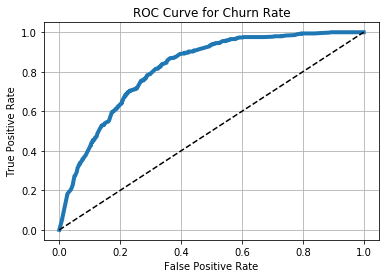

In [28]:
#understand and implement AUC ROC curve
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred_prob))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, linewidth = 4)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title ('ROC Curve for Churn Rate')
plt.plot([0, 1], [0, 1], "k--")
plt.grid()
plt.show()